<a href="https://colab.research.google.com/github/rnop/Numerai-Project/blob/main/Introduction_V4_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction - V4 Data
**This notebook requires Colab Pro or 16GB+ RAM to properly run.

#### Contents
* Read-in training, validation, and tournament V4 data
* Era Analysis
* Feature Analysis
* Target Analysis
* Model Training
  * Evaluation Metrics
  * Train-Test-Split
  * Era-Wise Time Series Cross-Validation
* Some Thoughts
  * Model Selection
  * Hyperparameter Tuning
  * NMR Staking and Currency Risk

In [1]:
# Install Numerai API
! pip install --upgrade numerapi

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from numerapi import NumerAPI

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Instantiate Numerai API
napi = NumerAPI()
current_round = napi.get_current_round(tournament=8) # tournament=8 is the main tournament
print("Current Round:", current_round)

Current Round: 315


### Read the V4 Data
** **WARNING** ** : your session might **crash** if you are not using Colab Pro's 'High-Ram' runtime feature or a computer w/ at least 16GB RAM. 

There are 3 datasets that Numerai provides you in the form of parquet/csv files:
* train
* validation
* live

It is up to you to decide your training/evaluation framework using the 'train' and 'validation' datasets. Typically, I combine the two and split them manually into training/validation/testing sets where I train my machine learning models on the training set, optimize and evaluate model hyperparameters using the validation set, and perform the final out-of-sample model evaluation on the testing set. 

The **live** dataset is the one you need your trained models to serve their prediction on to Numerai every week. This dataset **changes every week** as stocks are being traded globally. 

*Important note*: the observations in the live dataset are rolled every week into the validation set once the true targets are realized. 

In [4]:
# The official Numerai documentation has you read in their datasets like this

# napi.download_dataset("v4/train.parquet", "train.parquet")
# napi.download_dataset("v4/validation.parquet", "validation.parquet")
# napi.download_dataset("v4/live.parquet", "live.parquet")

If you are still running into RAM issues, I found you can download the int8 version which uses less VRAM and disk space:
* int8 converts floats to integers (eg. 1.0 -> 4)

In [5]:
napi.download_dataset("v4/train_int8.parquet", "train_int8.parquet")
napi.download_dataset("v4/validation_int8.parquet", "validation_int8.parquet") 
# napi.download_dataset("v4/live_int8.parquet", "live_int8.parquet")

2022-05-12 14:54:17,727 INFO numerapi.utils: starting download
train_int8.parquet: 1.15GB [00:25, 44.3MB/s]                            
2022-05-12 14:54:44,126 INFO numerapi.utils: starting download
validation_int8.parquet: 1.05GB [00:33, 31.2MB/s]                            


Due to RAM issues, this notebook will only use the training data! The validation data is very useful and I definitely recommend you use it for further model training and evaluation!

In [6]:
TRAIN_PATH = 'train_int8.parquet'

train_df = pd.read_parquet(TRAIN_PATH)
print("Training Shape:", train_df.shape)
train_df.head()

Training Shape: (2420521, 1214)


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,...,0.50,0.25,0.25,0.00,0.333333,0.000000,0.500000,0.500000,0.166667,0.000000
n003bee128c2fcfc,0001,train,2,4,1,3,0,3,2,3,...,0.75,1.00,1.00,1.00,0.666667,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.333333,0.500000,0.500000,0.333333
n00691bec80d3e02,0001,train,4,2,2,3,0,4,1,4,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,4,3,4,4,0,0,4,2,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000


In [7]:
VALIDATION_PATH = 'validation_int8.parquet'
valid_df = pd.read_parquet(VALIDATION_PATH)
print("Validation Shape:", valid_df.shape)
valid_df.head()

Validation Shape: (2219626, 1214)


,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,validation,2,0,4,0,3,0,4,1,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n001e1318d5072ac,0575,validation,1,4,2,2,1,3,3,0,...,0.00,0.25,0.00,0.50,0.166667,0.333333,0.333333,0.166667,0.166667,0.333333
n002a9c5ab785cbb,0575,validation,1,2,2,3,1,1,3,0,...,0.50,0.75,0.50,0.75,0.500000,0.666667,0.500000,0.666667,0.500000,0.666667
n002ccf6d0e8c5ad,0575,validation,2,4,2,4,2,4,3,2,...,0.25,0.00,0.25,0.00,0.166667,0.166667,0.333333,0.500000,0.333333,0.166667
n0051ab821295c29,0575,validation,2,0,0,1,0,4,2,1,...,0.50,0.50,0.50,0.50,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


### Eras
An important characteristic of the Numerai dataset is that the data is separated by eras corresponding to the data related to different periods of trading for each stock. The features and targets are recorded for all observations throughout each era. As a new era is realized (completed) it is added to the validation dataset for us to further update our models on. 

In [8]:
# Useful to convert 'era' column datatype from string to int
train_df['erano'] = train_df.era.astype(int)
train_eras = set(train_df['erano'])
print("Number of eras in the training set:", len(train_eras))

Number of eras in the training set: 574


One characteristic of the dataset that might be a problem is that the targets are 20-days (4 weeks) out while each era accounts for 5-days (1 week). If we attempt to train our model using the every era, we might run into data leakage. For example, the target for Era 1 is 20-days in the future, which means Era 2, 3, and 4 might contain information from the future relative to Era 1 before the 20-day target is realized. The future information may be leaked into our model training which can lead to overfitting and poor performance out-of-sample. Plus, the only information we will have when predicting the live dataset is the historical and current data. That being said, it could be useful to sample every 4th era to reduce the chance of data leakage. 

In [9]:
nonoverlap_train_eras = np.arange(min(train_eras), max(train_eras)+1, 4)
print(nonoverlap_train_eras)
train_df = train_df[train_df['erano'].isin(nonoverlap_train_eras)]

[  1   5   9  13  17  21  25  29  33  37  41  45  49  53  57  61  65  69
  73  77  81  85  89  93  97 101 105 109 113 117 121 125 129 133 137 141
 145 149 153 157 161 165 169 173 177 181 185 189 193 197 201 205 209 213
 217 221 225 229 233 237 241 245 249 253 257 261 265 269 273 277 281 285
 289 293 297 301 305 309 313 317 321 325 329 333 337 341 345 349 353 357
 361 365 369 373 377 381 385 389 393 397 401 405 409 413 417 421 425 429
 433 437 441 445 449 453 457 461 465 469 473 477 481 485 489 493 497 501
 505 509 513 517 521 525 529 533 537 541 545 549 553 557 561 565 569 573]


Do the same for the validation data

In [10]:
valid_df['erano'] = valid_df.era.astype(int)
validation_eras = set(valid_df['erano'])
print("Number of eras in the validation set:", len(validation_eras))

Number of eras in the validation set: 435


In [11]:
nonoverlap_validation_eras = np.arange(min(validation_eras), max(validation_eras)+1, 4)
print(nonoverlap_validation_eras)
valid_df = valid_df[valid_df['erano'].isin(nonoverlap_validation_eras)]

[ 575  579  583  587  591  595  599  603  607  611  615  619  623  627
  631  635  639  643  647  651  655  659  663  667  671  675  679  683
  687  691  695  699  703  707  711  715  719  723  727  731  735  739
  743  747  751  755  759  763  767  771  775  779  783  787  791  795
  799  803  807  811  815  819  823  827  831  835  839  843  847  851
  855  859  863  867  871  875  879  883  887  891  895  899  903  907
  911  915  919  923  927  931  935  939  943  947  951  955  959  963
  967  971  975  979  983  987  991  995  999 1003 1007]


In [12]:
# Combine training + validation and sample observations
combined_df = pd.concat([train_df, valid_df]).sample(600000, random_state=33)
combined_df = combined_df.dropna()
print("Combined DataFrame Shape: ", combined_df.shape)

Combined DataFrame Shape:  (583707, 1215)


### Feature Analysis
* There are 1191 features in the V4 dataset
* Some features are highly correlated (and uncorrelated) with other features
  * IMPORTANT: this correlation changes over time across different eras!
* Feature selection is an important step for training the best model

In [13]:
features = [col for col in combined_df if col.startswith('feature')]
print("Number of features:", len(features))

Number of features: 1191


In [14]:
# Compute the feature-target correlation within each era
feature_target_corr_df = pd.DataFrame(index=features).sort_index()
target = 'target'

for era in set(combined_df['erano']):
  feature_scores = {feature: score for feature, score in zip(features, np.corrcoef(combined_df[combined_df.erano==era][[target]+features].T)[1:,0])}
  feature_target_corr_df[f'era_{era}'] = pd.Series(feature_scores).sort_values()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


In [15]:
feature_target_corr_df.head()

,era_1,era_513,era_5,era_517,era_521,era_9,era_525,era_13,era_529,era_17,...,era_991,era_481,era_995,era_485,era_489,era_493,era_497,era_501,era_505,era_509
feature_aaronic_unexampled_arguer,0.039771,-0.025008,0.022135,0.042654,-0.010104,-0.005577,-0.017062,0.015987,0.007957,-0.051409,...,-0.027927,0.011556,-0.009424,0.001926,0.022428,-0.022803,-0.017837,-0.004399,-0.000938,0.008732
feature_abating_unadaptable_weakfish,0.030474,-0.033464,0.003213,-0.034412,-0.026574,-0.039879,0.001027,-0.028209,-0.019463,0.008260,...,0.068312,0.021112,0.018527,0.012474,0.024172,-0.029947,0.061314,-0.019151,0.056036,0.015872
feature_ablest_mauritanian_elding,-0.023756,-0.043326,0.021007,-0.030704,-0.015147,-0.007711,0.039538,-0.003753,-0.020669,-0.115698,...,0.014364,-0.042590,0.009332,0.023383,-0.044223,0.008491,-0.017784,-0.025900,0.021296,-0.033543
feature_abreast_viscoelastic_commander,0.029381,0.005607,0.042458,-0.014973,-0.016879,0.045517,0.029190,0.066484,0.025262,-0.039603,...,0.021665,0.028300,-0.040381,0.020296,0.003046,0.002398,0.003780,-0.003119,0.028674,-0.021400
feature_acanthoid_slimiest_decor,-0.021536,-0.002274,0.035734,-0.038543,0.000948,0.010053,-0.012065,0.013100,0.012642,0.009349,...,0.010584,-0.019440,-0.014025,-0.007896,-0.008058,0.027004,-0.047891,-0.016468,0.001142,0.043170


In [16]:
# Compute Descriptive Statistics for Each Feature-Target Correlations Across Eras
feature_target_eras = [c for c in feature_target_corr_df if c.startswith("era_")]
feature_target_corr_df['mean_corr'] = feature_target_corr_df[feature_target_eras].mean(axis=1)
feature_target_corr_df['abs_mean_corr'] = abs(feature_target_corr_df['mean_corr'])
feature_target_corr_df['std_corr'] = feature_target_corr_df[feature_target_eras].std(axis=1)
feature_target_corr_df['positive_era_proportion'] = feature_target_corr_df[feature_target_corr_df[feature_target_eras] > 0].count(axis=1) / len(feature_target_eras)

In [17]:
erawise_desc_stats = ['mean_corr', 'abs_mean_corr', 'std_corr', 'positive_era_proportion']
feature_target_corr_df[erawise_desc_stats].sort_values('mean_corr', ascending=False).round(6)[:10] #Sort by highest mean correlation

,mean_corr,abs_mean_corr,std_corr,positive_era_proportion
feature_fourieristic_allied_mugwumpery,0.012727,0.012727,0.037885,0.624
feature_splashier_conservant_ultramarine,0.011505,0.011505,0.037955,0.632
feature_nonnegotiable_errant_soya,0.010789,0.010789,0.038748,0.632
feature_bifocal_disposable_clacton,0.010223,0.010223,0.038753,0.624
feature_headiest_unguessed_religion,0.009789,0.009789,0.037394,0.616
feature_simpatico_cadential_pup,0.009494,0.009494,0.025618,0.656
feature_epigraphic_leucocratic_rutherford,0.009419,0.009419,0.026457,0.624
feature_meteorological_tushed_ester,0.009414,0.009414,0.024628,0.640
feature_sodding_choosy_eruption,0.009145,0.009145,0.027238,0.592
feature_cyclopedic_maestoso_daguerreotypist,0.009095,0.009095,0.023195,0.632


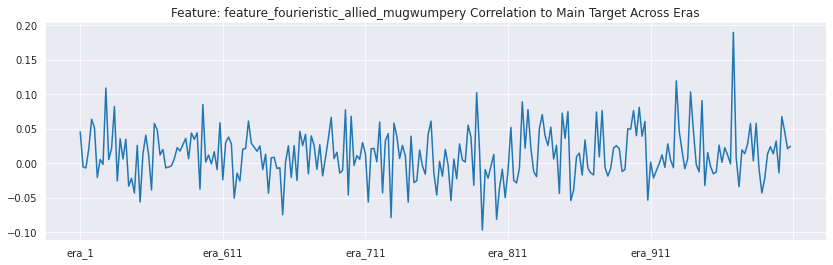

In [18]:
feature_name = 'feature_fourieristic_allied_mugwumpery'
plt.title(f"Feature: {feature_name} Correlation to Main Target Across Eras")
feature_target_corr_df.loc[feature_name][feature_target_eras].plot(figsize=(14,4))
plt.show()

In [19]:
# Absolute mean correlation might be more useful!
feature_target_corr_df[erawise_desc_stats].sort_values('abs_mean_corr', ascending=False).round(6)[:10] #Sort by highest mean correlation

,mean_corr,abs_mean_corr,std_corr,positive_era_proportion
feature_unsustaining_chewier_adnoun,-0.017930,0.017930,0.027726,0.268
feature_coastal_edible_whang,-0.017694,0.017694,0.027997,0.280
feature_steric_coxcombic_relinquishment,-0.017204,0.017204,0.027432,0.272
feature_trisomic_hagiographic_fragrance,-0.017198,0.017198,0.027797,0.284
feature_censorial_leachier_rickshaw,-0.016967,0.016967,0.027635,0.268
feature_third_discreet_solute,-0.015345,0.015345,0.037998,0.364
feature_unconjugal_chiropodial_amorosity,-0.013912,0.013912,0.038837,0.376
feature_terroristic_tripersonal_pashm,-0.013106,0.013106,0.038383,0.376
feature_fourieristic_allied_mugwumpery,0.012727,0.012727,0.037885,0.624
feature_undisguised_unenviable_stamen,-0.012675,0.012675,0.037216,0.380


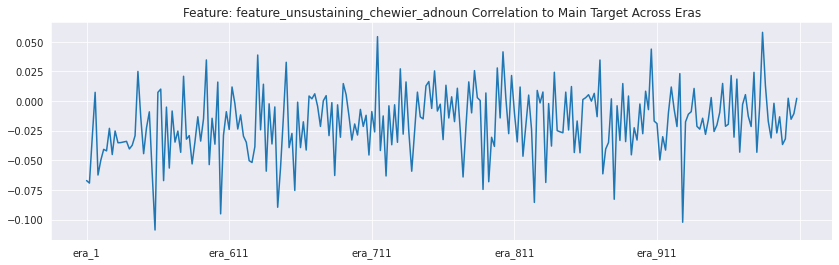

In [20]:
feature_name = 'feature_unsustaining_chewier_adnoun'
plt.title(f"Feature: {feature_name} Correlation to Main Target Across Eras")
feature_target_corr_df.loc[feature_name][feature_target_eras].plot(figsize=(14,4))
plt.show()

Looks like 'feature_coastal_edible_whang' has a mostly negative correlation with the main target!

In [21]:
# Might be interested in Volatile Features (highest standard deviation)
feature_target_corr_df[erawise_desc_stats].sort_values('std_corr', ascending=False).round(6)[:10] #Sort by highest mean correlation

,mean_corr,abs_mean_corr,std_corr,positive_era_proportion
feature_ruthenic_peremptory_truth,-0.008914,0.008914,0.044797,0.440
feature_comprisable_commensurable_cyrenaic,-0.008912,0.008912,0.044281,0.440
feature_carbuncled_athanasian_ampul,-0.008258,0.008258,0.043600,0.440
feature_flamier_confusing_dithering,-0.009785,0.009785,0.043204,0.408
feature_lowery_transcribed_muffin,-0.007285,0.007285,0.042170,0.424
feature_pardonable_ungraceful_bedazzlement,-0.007706,0.007706,0.041793,0.440
feature_fearsome_merry_bluewing,-0.010989,0.010989,0.041763,0.404
feature_unholy_residential_anabaptism,-0.007753,0.007753,0.041657,0.420
feature_profaned_exothermal_orczy,-0.008814,0.008814,0.041501,0.432
feature_elaborate_burning_drunkard,-0.007212,0.007212,0.041358,0.428


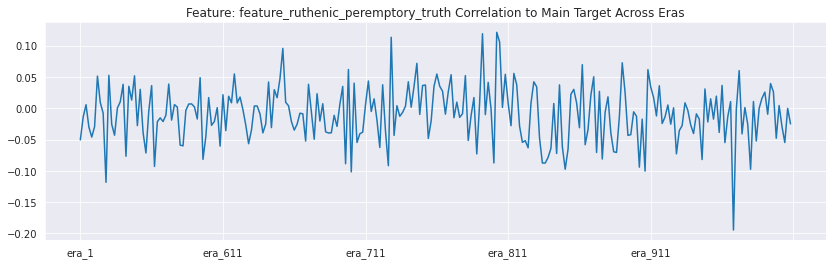

In [22]:
feature_name = 'feature_ruthenic_peremptory_truth'
plt.title(f"Feature: {feature_name} Correlation to Main Target Across Eras")
feature_target_corr_df.loc[feature_name][feature_target_eras].plot(figsize=(14,4))
plt.show()

Looks like 'feature_ruthenic_peremptory_truth' yields eras with both extreme positive and negative correlations to the target. Truly volatile!

Quick Feature Selection: Choose the least volatile features
* Let's choose features that are within 1 standard deviation of the mean standard deviation

In [23]:
print(feature_target_corr_df['std_corr'].describe().loc[['mean', 'std']])
mean = feature_target_corr_df['std_corr'].describe().loc['mean']
std = feature_target_corr_df['std_corr'].describe().loc['std']

mean    0.024754
std     0.004518
Name: std_corr, dtype: float64


In [24]:
top_threshold = mean + std
bot_threshold = mean - std
nonvolatile_features_df = feature_target_corr_df[feature_target_corr_df['std_corr'].between(bot_threshold, top_threshold)]
nonvolatile_features = nonvolatile_features_df.index.tolist()
nonvolatile_features_df['std_corr'].describe()

count    927.000000
mean       0.024293
std        0.002085
min        0.020250
25%        0.022747
50%        0.024151
75%        0.025819
max        0.029271
Name: std_corr, dtype: float64

By selecting only the nonvolatile features, we've reduced the number of features of the dataset from 1191 to 927 for our model to train on.

### Target Analysis
* The main target we want to predict is 'target' and 'target_nomi_v4_20' (they are identical)
* There are 21 targets in the V4 dataset that you can possibly train your model on
* Differentiate from 20-day to 60-day targets and target different outcomes (but can be similar to the main target!)

In [25]:
targets = [col for col in combined_df if col.startswith('target')]
target = 'target'
print("Number of targets:", len(targets))
print("Example targets:", targets[5:10]) # Sample some targets)
print("Main target:", target)

Number of targets: 21
Example targets: ['target_janet_v4_20', 'target_janet_v4_60', 'target_ben_v4_20', 'target_ben_v4_60', 'target_alan_v4_20']
Main target: target


In [26]:
print("Target Correlations to Main Target")
combined_df[targets].corr()['target'].sort_values(ascending=False)

Target Correlations to Main Target


target                  1.000000
target_nomi_v4_20       1.000000
target_thomas_v4_20     0.879453
target_william_v4_20    0.864962
target_ben_v4_20        0.816130
target_jerome_v4_20     0.796203
target_paul_v4_20       0.777367
target_arthur_v4_20     0.727221
target_george_v4_20     0.720470
target_janet_v4_20      0.694748
target_alan_v4_20       0.685655
target_nomi_v4_60       0.503233
target_thomas_v4_60     0.486099
target_william_v4_60    0.479958
target_ben_v4_60        0.454045
target_jerome_v4_60     0.442816
target_paul_v4_60       0.426803
target_arthur_v4_60     0.405836
target_george_v4_60     0.400577
target_janet_v4_60      0.390894
target_alan_v4_60       0.388179
Name: target, dtype: float64

It looks like most of the 20-day targets are more correlated to the main target than the 60-day targets. It might be useful to develop a framework incorporating multiple targets for your model. 

### Model Training
1. Define Model Evaluation Metrics
2. Standard Train-Test Split
2. Era-wise Time Series Cross-Validation

#### 1. Model Evaluation Metrics - CORR & Sharpe

In [27]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

def score(df, prediction):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df['target'],
        df[prediction].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print()
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print(f"Max Drawdown: {np.min(era_scores):.4f}")
    print()
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(5).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

#### 2. Train-Test-Split
One approach to train and test a model is using the train-test-split framework where we split our combined dataset into training and testing sets by randomly sampling observations into each set. Typically, one would use 80% of the dataset for training model and the remaining 20% of the dataset for testing the model on unseen data. 

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_df[nonvolatile_features], combined_df['target'], test_size=0.25, random_state=33)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (437780, 927)
X_test shape: (145927, 927)


#### Train a LightGBM Model

In [29]:
import lightgbm

if 'lgb_example.txt' is True: # Check if model is saved in current directory
  print("Loading LightGBM model...")
  lgb = lightgbm.Booster(model_file='lgb_example.txt')

else:
  print("Training LightGBM model...")
  # Hyperparameters are given from Numerai example script
  params = {"n_estimators": 200,
            "learning_rate": 0.01,
            "max_depth": 5,
            "num_leaves": 2**5,
            "colsample_bytree": 0.1}

  lgb = lightgbm.LGBMRegressor(**params) # Instantiate model
  lgb.fit(X_train, y_train) # Train model
  print("Saving model...")
  lgb.booster_.save_model('lgb_example.txt') # Save model
  print("Training done.")

Training LightGBM model...
Saving model...
Training done.


Evaluating Testing Set...

Correlation Score:  0.03748437662478474

count    145927.000
mean          0.500
std           0.004
min           0.471
25%           0.498
50%           0.500
75%           0.503
max           0.524
dtype: float64



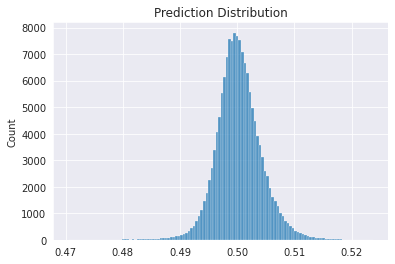

In [30]:
# Evaluate Testing Data
print("Evaluating Testing Set...")
print()
test_predictions = lgb.predict(X_test)
# Correlation Score
print("Correlation Score: ", correlation_score(y_test, test_predictions))
print()

# Check distribution of predictions
print(pd.Series(test_predictions).describe().round(3))
print()
plt.title("Prediction Distribution")
sns.histplot(test_predictions, bins=120)
plt.show()
print()

Using the train-test-split framework, we trained a LightGBM model that achieved a 0.3748 correlation score on the testing set. This would be considered an average model for the Numerai tournament. However, there are a lot problems when using this framework specifically this type of time series data. Our model might be susceptible to data leakage leading to overfitting and misleading results. When we split our dataset using the train-test-split framework, we essentially randomly select observations into the training and testing sets. Recall that our dataset is time series-like so the random selection will result in future data being used to train the model that might contain information about observations being be predicted in the test set. Using valuable information from the future that should not be available at the time of prediction for a particular observation is very dangerous for the confidence in our model. This data leakage will inflate our testing scores to mislead our confidence for future predictions on the actual live stock market data. For this reason, I propose using the Era-Wise Time Series Cross-Validation technique to more confidently train and evaluate your models.

### Era-Wise Time Series Cross-Validation
Since we are dealing with a time-series-like data set, we could further reduce the potential of data leakage across eras by performing an customized era-wise time-series cross-validation technique. 

The general idea is to evaluate a model and its hyperparameters by developing a sequential cross-validation framework stratified by eras. We will train our model on folds consisting of earlier eras and evaluating on folds consisting of later eras. This gives us a more confident method for model evaluation on the live tournament data.

Running Era-Wise Time Series Cross-Validation Using 7-Splits

Training Eras Split (0.999, 185.0]
Training Size:  (85117, 1215)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Correlation: 0.0280
Median Correlation: 0.0281
Standard Deviation: 0.0294

Mean Pseudo-Sharpe: 0.9547
Median Pseudo-Sharpe: 0.9580
Max Drawdown: -0.0496

Hit Rate (% positive eras): 84.40%


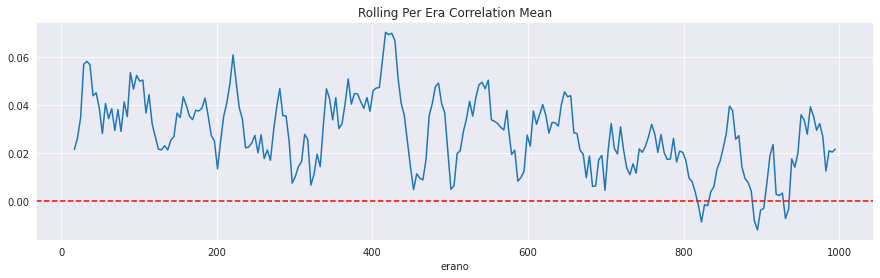

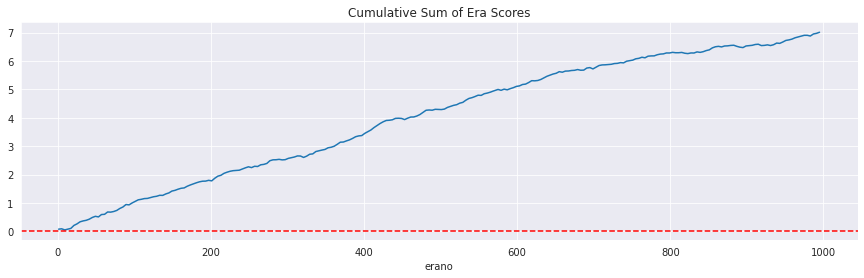

Correlation Score: 0.027425599369688913

Training Eras Split (185.0, 329.0]
Training Size:  (167778, 1215)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Correlation: 0.0324
Median Correlation: 0.0337
Standard Deviation: 0.0325

Mean Pseudo-Sharpe: 0.9977
Median Pseudo-Sharpe: 1.0361
Max Drawdown: -0.0466

Hit Rate (% positive eras): 83.60%


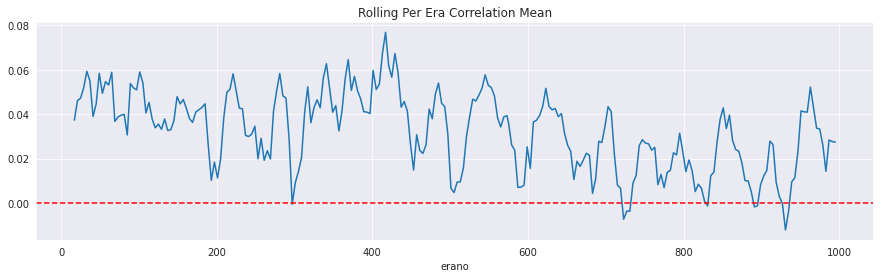

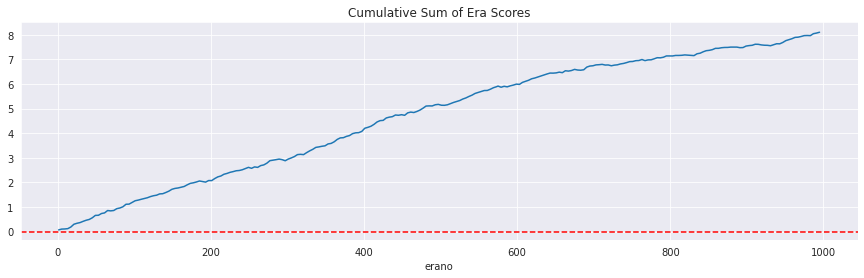

Correlation Score: 0.03269426851708808

Training Eras Split (329.0, 473.0]
Training Size:  (250451, 1215)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Correlation: 0.0345
Median Correlation: 0.0332
Standard Deviation: 0.0364

Mean Pseudo-Sharpe: 0.9466
Median Pseudo-Sharpe: 0.9099
Max Drawdown: -0.0798

Hit Rate (% positive eras): 84.00%


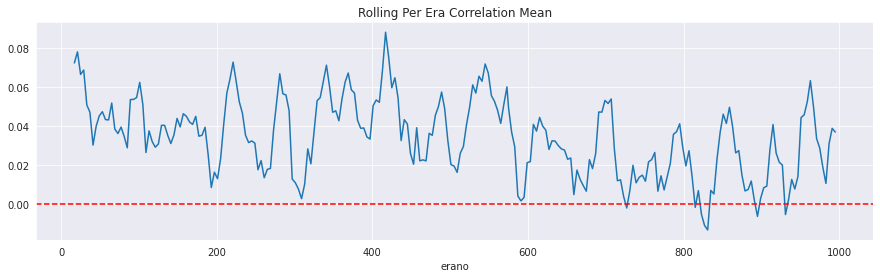

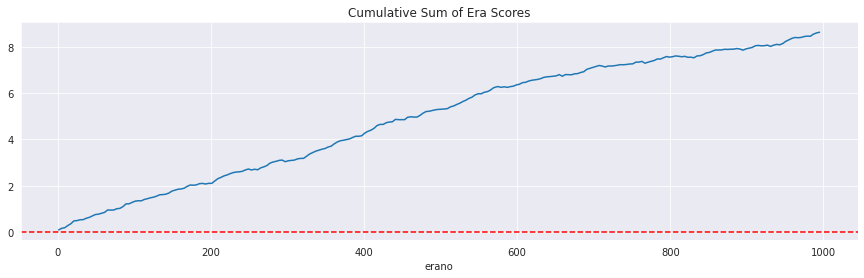

Correlation Score: 0.03350894902738724

Training Eras Split (473.0, 611.0]
Training Size:  (334614, 1215)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Correlation: 0.0338
Median Correlation: 0.0352
Standard Deviation: 0.0401

Mean Pseudo-Sharpe: 0.8427
Median Pseudo-Sharpe: 0.8784
Max Drawdown: -0.1007

Hit Rate (% positive eras): 80.00%


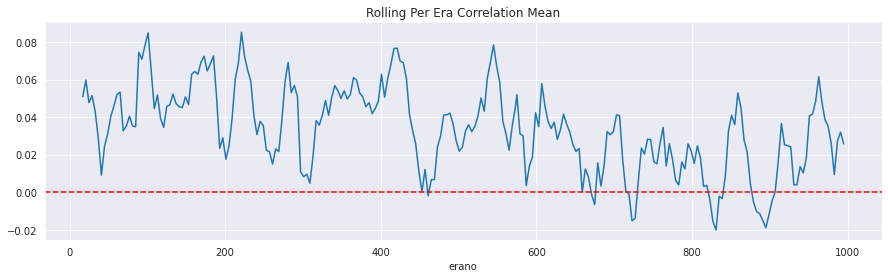

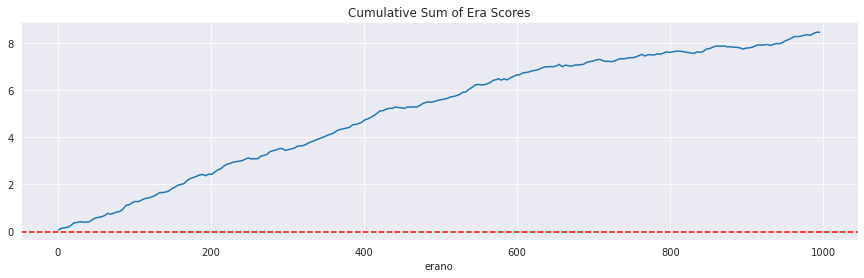

Correlation Score: 0.03423586652968483

Training Eras Split (611.0, 743.0]
Training Size:  (418406, 1215)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Correlation: 0.0308
Median Correlation: 0.0328
Standard Deviation: 0.0470

Mean Pseudo-Sharpe: 0.6541
Median Pseudo-Sharpe: 0.6977
Max Drawdown: -0.1153

Hit Rate (% positive eras): 77.20%


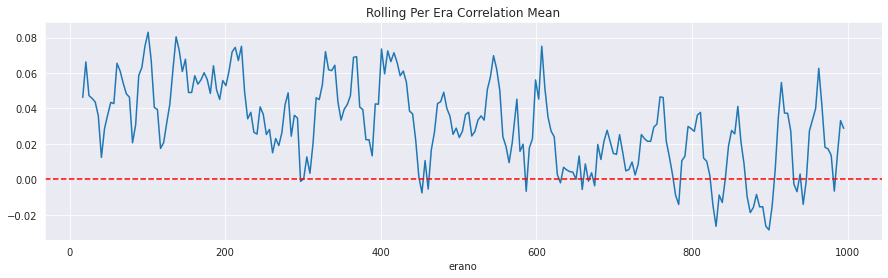

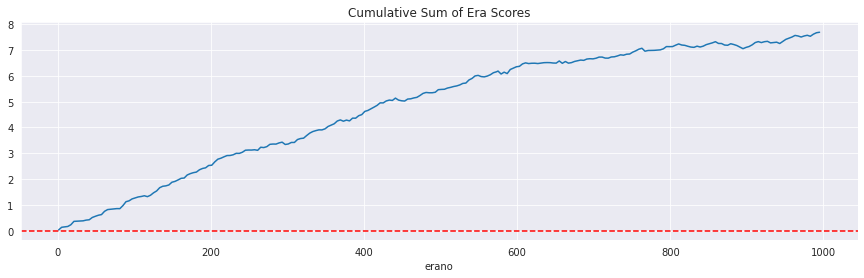

Correlation Score: 0.03105736126958583

Training Eras Split (743.0, 871.0]
Training Size:  (501731, 1215)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mean Correlation: 0.0266
Median Correlation: 0.0261
Standard Deviation: 0.0588

Mean Pseudo-Sharpe: 0.4530
Median Pseudo-Sharpe: 0.4435
Max Drawdown: -0.1584

Hit Rate (% positive eras): 69.20%


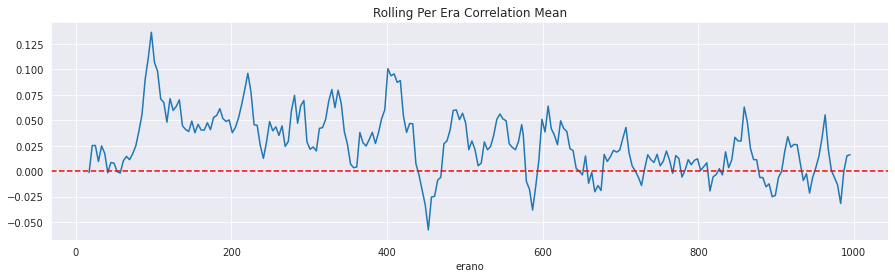

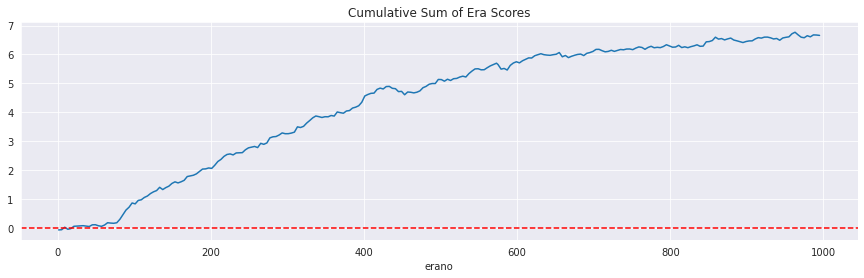

Correlation Score: 0.028554849359355473

Cumulative Scores
Model:  LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=200, num_leaves=32)
Correlation Scores:  [0.027425599369688913, 0.03269426851708808, 0.03350894902738724, 0.03423586652968483, 0.03105736126958583, 0.028554849359355473]
Mean Predictions (6-splits):  0.031246149012131727
Std. Dev Predictions (6-splits):  0.0025176397361940123


In [35]:
n_splits = 7
print(f"Running Era-Wise Time Series Cross-Validation Using {n_splits}-Splits")
gr = combined_df['erano'].groupby(pd.qcut(combined_df['erano'], n_splits))

corr_scores = []
split_no = 0
idx = 0
for key, group in gr:
  split_no += 1
  if split_no != n_splits:
    idx += group.shape[0]
    train = combined_df.iloc[:idx]
    test = combined_df.iloc[idx:]
    print()
    print("Training Eras Split", key)
    print("Training Size: ", train.shape)

    try: 
      # We will train a LightGBM with the same hyperparameters as before
      params = {"n_estimators": 200,
                "learning_rate": 0.01,
                "max_depth": 5,
                "num_leaves": 2**5,
                "colsample_bytree": 0.1}
                
      # model = lightgbm.LGBMRegressor(**params)
      model = lightgbm.LGBMRegressor(**params) 

      # Train Model On Earlier Eras
      model.fit(train[nonvolatile_features], train[target])

      # Evaluate Model on Later Eras
      test['prediction'] = model.predict(test[nonvolatile_features])
      mean_test_era_scores = test.groupby(test['erano']).apply(score, prediction='prediction')
      run_analytics(mean_test_era_scores)

      corr_score = correlation_score(test['target'], test['prediction'])
      corr_scores.append(corr_score)
      print("Correlation Score:", corr_score)

    except:
      continue

print()
print("Cumulative Scores")
print("Model: ", model)
print("Correlation Scores: ", corr_scores)
print(f"Mean Predictions ({len(corr_scores)}-splits): ", np.mean(corr_scores))
print(f"Std. Dev Predictions ({len(corr_scores)}-splits): ", np.std(corr_scores))

Using Era-Wise Time Series Cross-Validation, we find that the average correlation score across era-splits is 0.03124 for our LightGBM model which is a more confident evaluation score than using the previous train-test-split method. This method also makes sense to use because we will use the whole combined dataset (train_df + valid_df) from Numerai to train our final model and believe we will achieve similar performance on the live data. 

## Some thoughts

### Model Selection
I have found that tree-based models like XGBoost and LightGBM are the easiest to train and produce decent results on the live data. You can train linear models like Ridge or Linear Regression but I found that these models are quite volatile and can have dangerous drawdowns resulting in massive losses. Neural networks can be very useful but building the right framework of layers and activation functions can be tedious and often result in overfitting.  

### Hyperparameter Tuning
One of the things that was not covered in this notebook was finding the best set of hyperparameters to tune our machine learning model. The hyperparameters chosen for our LightGBM model was taken from the official Numerai scripts on their GitHub. However, it is good practice to select a hyperparameter optimization framework such as grid search or Bayesian optimization to find the best set of hyperaparameters.  

### $NMR Staking and Currency Risk
This section only applys if you plan on staking your model in the tournament. 
Another important and often overlooked aspect of the tournament is the currency risk when staking with their NMR cryptocurrency. The NMR-USD pairing has been quite volatile resulting in seemingly unknown spikes of prices in both directions. When you stake your model, you are essentially going long on NMR as well so it might be important to think about the NMR price and overall cryptocurrency markets when deciding to invest in your model.

Furthermore, there is a 4-week staking period for each round in the tournament which essentially means you will be unable to withdraw and sell your NMR within that staking period where your model is active.